# Splines


- Assume $(X,Y) \in \mathbb R^p\times \mathbb R$


- Goal: approximate true regression function $f(X) = E[Y|X]$


- GLM assumption: $g(E[Y|X])= X\beta$, is a linear function of $X$ so $f(X) = g^{-1}(X\beta)$ where $\beta = (\beta_0,\beta_1,\dots,\beta_p)$

$$\\[0.5in]$$

- Question: What are the chances that the true regression function takes a GLM form, $E[Y|X] = g^{-1}(X\beta)$, for any real-world application? (choose one)
    - A. Very high
    - B. Somewhat high
    - C. Very low
    - D. No chance at all

$$\\[0.5in]$$
    
- Question: Why ever assume linearity? (choose all that apply)
    - A. Simplicity
    - B. Interpretability
    - C. Minimal risk of overfitting
    - D. First-order Taylor approximation of true regression function $E[Y|X]$

$$\\[0.5in]$$

- Splines are regression techniques that allow more complex functional relationships between $Y$ and $X$


- If $p=1$ (if there is only one column in the data), a spline would take the form $g(E[Y|X])= \sum_{m=1}^M \beta_m h_m(X)$


- $h_1, \dots, h_M$ are transformations of $X$


- $g(E[Y|X])$ is modeled as a GLM of the transformation


- As the number of transformations, $M$, increases, so does model complexity


![](./overfitting.png)


- Typically, the challenge is in choosing the appropriate $M$

$$\\[0.5in]$$

- Question: How would you choose $M$?
    - A. Best subset selection
    - B. Lasso
    - C. Visual inspection
    - D. AIC
    - E. Not sure

$$\\[0.5in]$$

- It is not often the case that we only want to model a single column


- Generalized Additive model: when $p>1$, $$g(E[Y|X])= \sum_{j=1}^p \sum_{m=1}^{M_j} \beta_{mj} h_{mj}(X_j)$$


- Here, must choose $M_j$ for each variable $X_j$


- Let's start with a toy example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrix
import seaborn as sns
%matplotlib inline

In [2]:
# true regression function
def f(x):
    return(x*(x-5)*(x-10)/np.exp(x)+3)

n = 500 # sample size
x = np.sort(np.random.uniform(low=0, high=10, size=n))
y = f(x)+np.random.normal(0, 3, n)

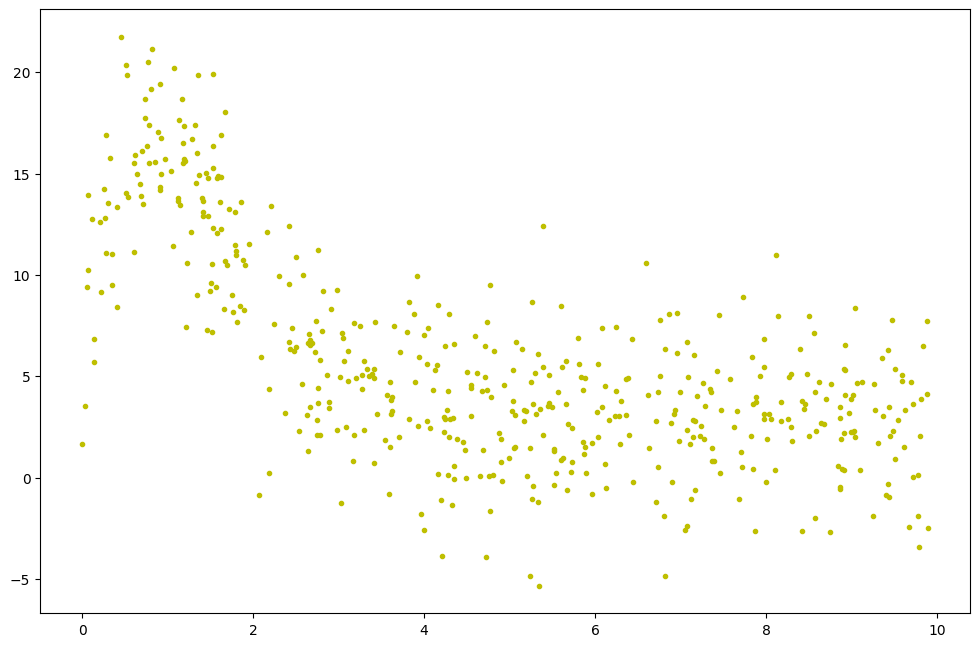

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(x,y,'.y')
plt.show()

- Question: Would simple linear regression do a good job here?
    - A. Yes
    - B. No
    - C. Not sure

$$\\[0.5in]$$

- In real life, we wouldn't know the true regression function


- I would question what was happening with points near $X=0$


- Could they be outliers?


- In this case, they provide information

In [4]:
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     372.9
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           1.96e-62
Time:                        10:49:51   Log-Likelihood:                -1406.5
No. Observations:                 500   AIC:                             2817.
Df Residuals:                     498   BIC:                             2825.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7094      0.355     32.971      0.000      11.012      12.407
x1            -1.2272      0.064    -19.311      0.000      -1.352      -1.102
==============================================================================
Omnibus:                        0.851   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.940
Skew:                           0.054   Prob(JB):                        0.625
Kurtosis:                       2.817   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

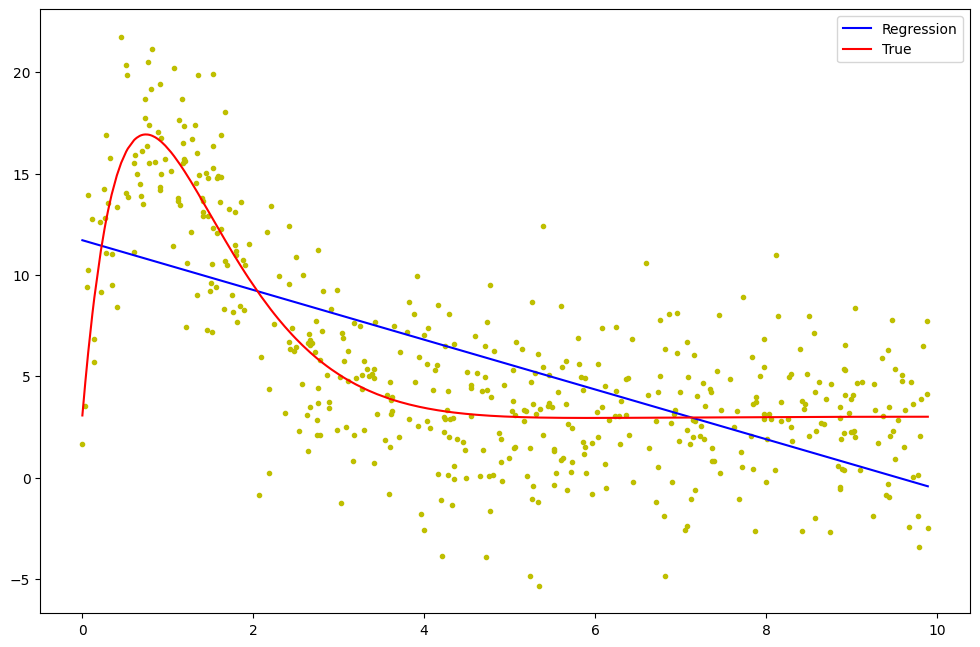

In [5]:
plt.plot(x,y,'.y')
plt.plot(x, x*results.params[1]+results.params[0], '-b',
         label='Regression')
plt.plot(x, f(x), '-r', label='True')
plt.legend();

- Clear that fit is not perfect


- Is seeing the true regression function influencing our feelings about the true model?

$$\\[0.5in]$$

- Question: If prediction is the primary objective, would the linear model be ok?
    - A. Yes
    - B. No
    - C. Depends on more things
    - D. Not sure

$$\\[0.5in]$$

- Question: If inference were our goal, would this model be ok?
    - A. Yes
    - B. No
    - C. Depends on more things
    - D. Not sure

$$\\[0.5in]$$

- If this were our only variable, it would be important to take time to try to understand it better


- If this were one variable among many, it would depend on how well this variable explains the outcome


- Typically, outcomes have many sources of variation, not just one


- A linear model could still be helpful, depending on setting


- Easy to interpret: on average, for each unit increase in x, there is a statistically significant ($p<0.001$) 1.2 unit decrease in y


- Let's see how a smoothing spline does

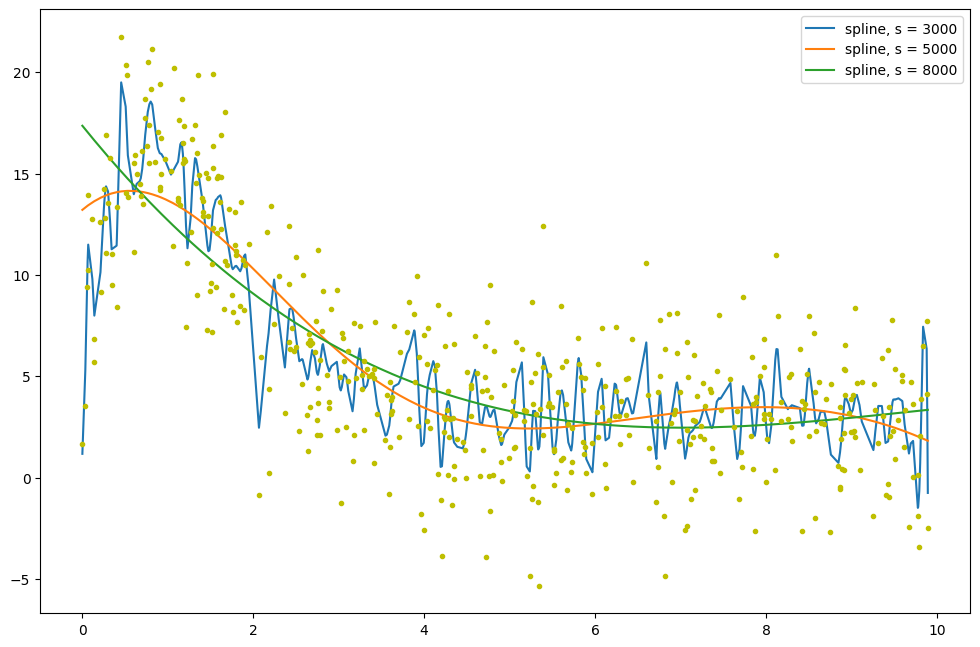

In [6]:
from scipy.interpolate import UnivariateSpline

spl = UnivariateSpline(x, y)

for sm_fact in [3000, 5000, 8000]:
    spl.set_smoothing_factor(sm_fact)
    plt.plot(x, spl(x), label=f"spline, s = {np.round(sm_fact)}")

plt.plot(x,y,'.y')
plt.legend();

- Question: Which spline appears best?
    - A. $s=3000$
    - B. $s=5000$
    - C. $s=8000$
    - D. Not sure

$$\\[0.5in]$$


- This plot is too busy but it shows how important choosing complexity is to fitting splines


- From these three, $s=5000$ seems to have the best fit


- The spline parameter estimates are not easily interpretable but a plot with the single $s=5000$ curve does explain the conditional mean well


- Let's compare the spline to the true regression curve

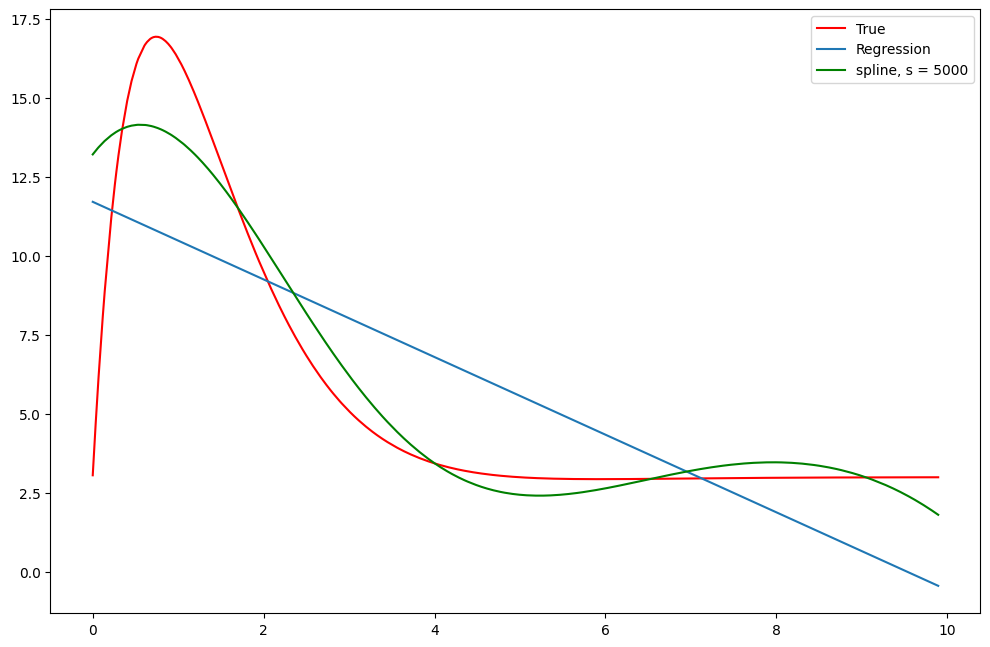

In [7]:
plt.plot(x, f(x), '-r', label='True')
plt.plot(x, x*results.params[1]+results.params[0], '-',
         label='Regression')

spl = UnivariateSpline(x, y)

sm_fact = 5000
spl.set_smoothing_factor(sm_fact)
plt.plot(x, spl(x), '-g', label=f"spline, s = {np.round(sm_fact)}")
plt.legend();

- The spline is still not perfect but better than linear

$$\\[0.5in]$$

- Question: Is the spline model interpretable?
    - A. Yes
    - B. No
    - C. Not sure

$$\\[0.5in]$$

### Case Study: South African Heart Disease

- Subset of Coronary Risk-Factor Study (CORIS) baseline survey from 1983


- Data collected in 3 rural areas of the Western Cape, South Africa


- Aim: Establish intensity of ischemic heart disease risk factors


- Note: Western Cape is a high-incidence region


- Data: White males between age 15 and 64


- Outcome: Past myocardial infarction (CHD in the data) at time of survey (prevalence 5.1%)


- Question: Why not use proportional hazards regression here?
    - A. This dataset is a subset of another dataset
    - B. The study group (white males) is too monolithic
    - C. There is no time to event data
    - D. Not sure

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

Data dictionary:

- **sbp:** systolic blood pressure


- **tobacco:** cumulative tobacco (kg)


- **ldl:** low density lipoprotein cholesterol


- **famhist:** family history of heart disease (Present, Absent)


- **obesity:** body mass index (bmi)


- **age:** age at onset


- **chd:** response, coronary heart disease


**Goal:** For this task, our primary objective is prediction (not inference), but we want to be able to interpret the model as well

In [8]:
url = 'https://web.stanford.edu/~hastie/ElemStatLearn//datasets/SAheart.data'
dat = pd.read_csv(url)
dat = dat[['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age', 'chd']]
print(dat.shape)
dat.head()

(462, 7)


,sbp,tobacco,ldl,famhist,obesity,age,chd
0,160,12.00,5.73,Present,25.30,52,1
1,144,0.01,4.41,Absent,28.87,63,1
2,118,0.08,3.48,Present,29.14,46,0
3,170,7.50,6.41,Present,31.99,58,1
4,134,13.60,3.50,Present,25.99,49,1


In [9]:
dat.describe().round(2)

,sbp,tobacco,ldl,obesity,age,chd
count,462.00,462.00,462.00,462.00,462.00,462.00
mean,138.33,3.64,4.74,26.04,42.82,0.35
std,20.50,4.59,2.07,4.21,14.61,0.48
min,101.00,0.00,0.98,14.70,15.00,0.00
25%,124.00,0.05,3.28,22.98,31.00,0.00
50%,134.00,2.00,4.34,25.80,45.00,0.00
75%,148.00,5.50,5.79,28.50,55.00,1.00
max,218.00,31.20,15.33,46.58,64.00,1.00


- Note: `describe` by default only looks at numeric variables
- Must also look at non-numeric variables as well

In [10]:
print(dat.dtypes)
dat.describe(include='object')
dat.famhist.value_counts()

sbp          int64
tobacco    float64
ldl        float64
famhist     object
obesity    float64
age          int64
chd          int64
dtype: object


Absent     270
Present    192
Name: famhist, dtype: int64

- Exploring data


- `seaborn` has some nice exploratory data visualization methods

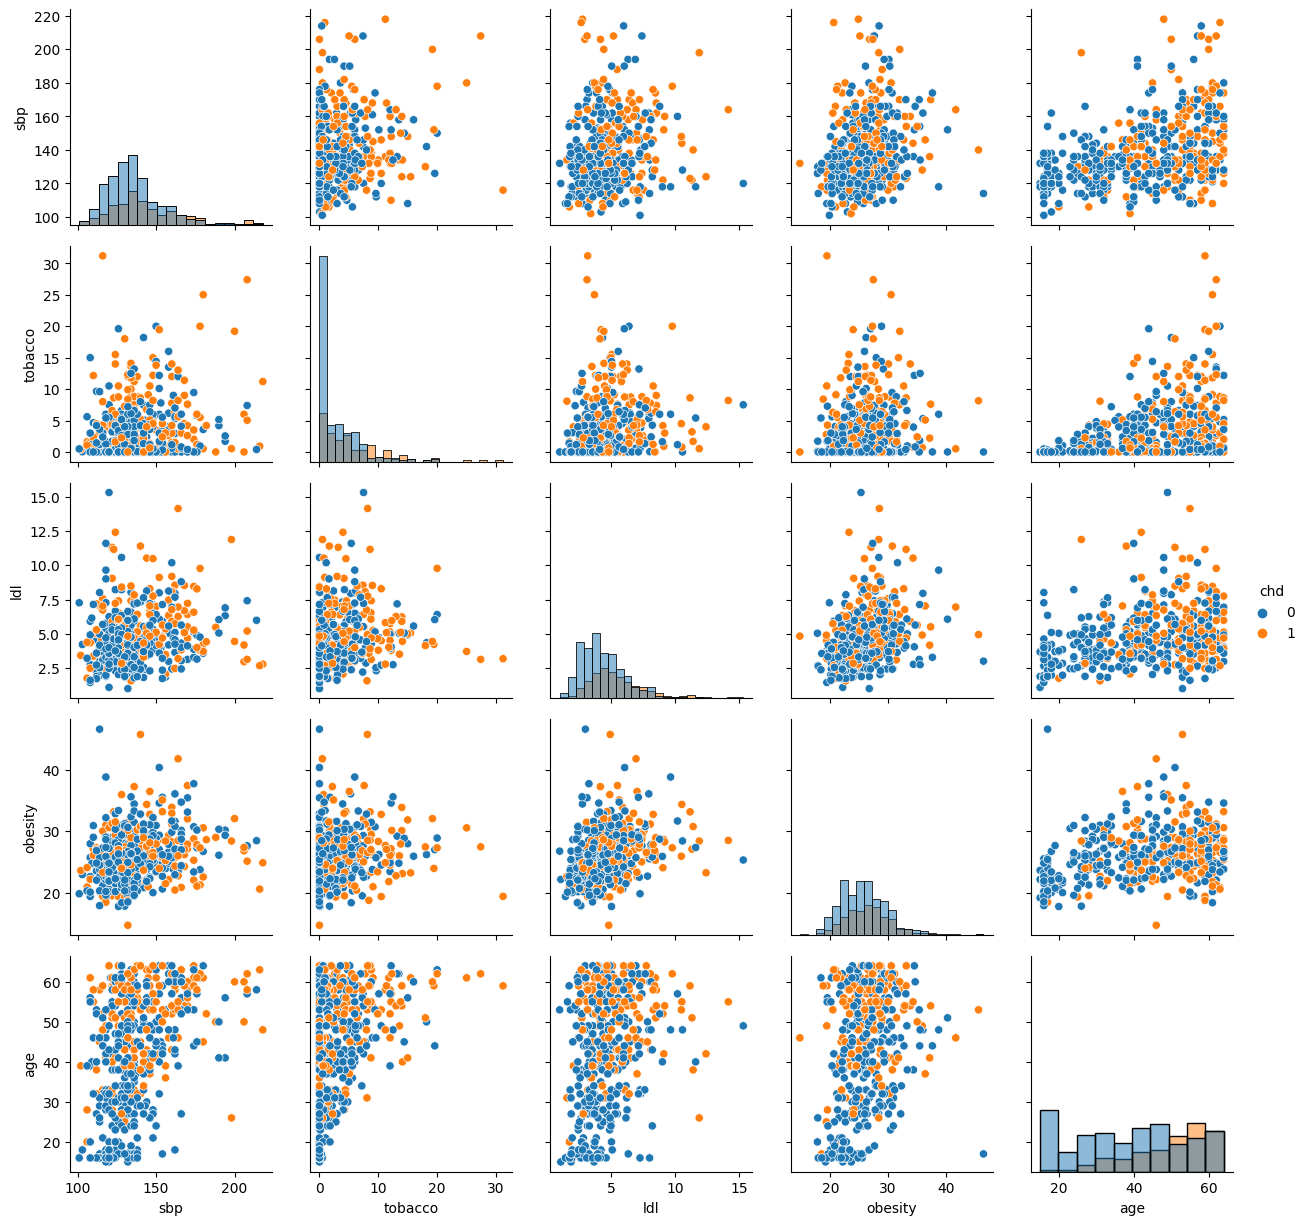

In [11]:
g = sns.PairGrid(dat, hue="chd")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

- **Violin** plots can be more helpful by showing the densities more clearly


- This can be helpful for bimodal densities


- An alternative is a box plot

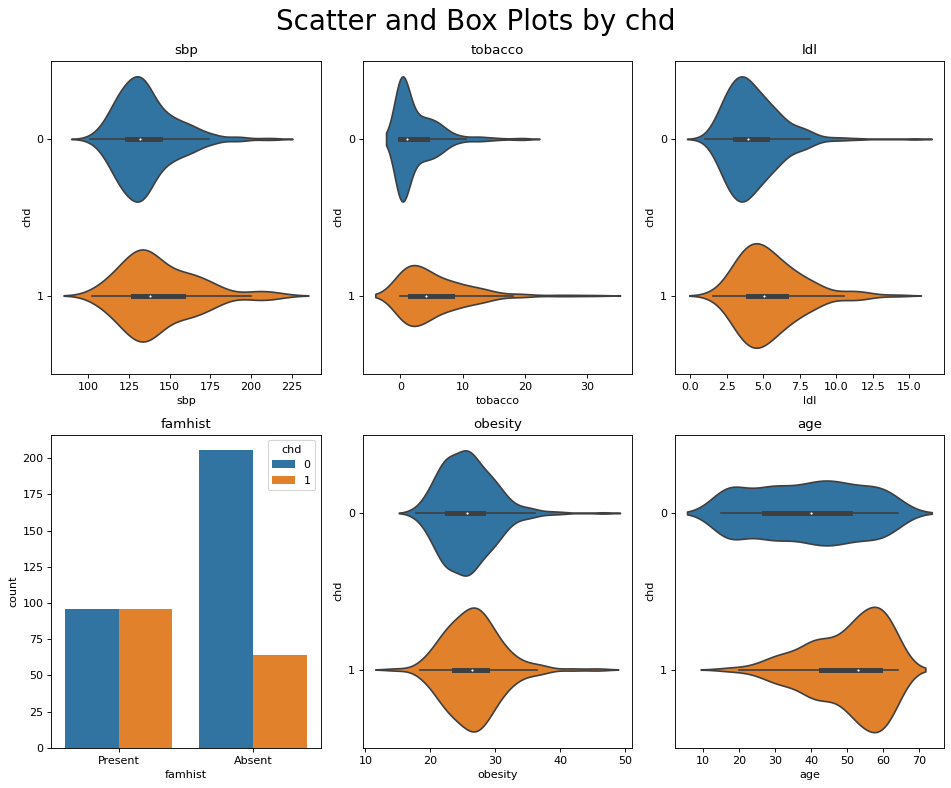

In [12]:
def draw_outcome_plots(df, outcome, n_rows, n_cols):
    fig=plt.figure(figsize=(12, 10), dpi=80)
    variables = df.columns.drop(outcome)
    for itr, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,itr+1)
        if len(df[var_name].unique()) > 10:
            sns.violinplot(ax=ax, x=var_name, y=outcome, 
                           orient='h', data=df)
        else:
            sns.countplot(ax=ax, x=var_name, hue=outcome, 
                          data=df);
        ax.set_title(var_name)
    fig.suptitle('Scatter and Box Plots by '+outcome,
                 size=25)
    fig.tight_layout()
    plt.show()

draw_outcome_plots(dat, 'chd', 2, 3)

- Question: Do you see any nonlinear trends in these plots?
    - A. Yes
    - B. No
    - C. Not sure

$$\\[0.5in]$$


- It can be difficult to see nonlinear trends in binary data


### Modeling

- Question: Because we're not doing inference here, is overfitting possible?
    - A. Yes
    - B. No
    - C. Not sure

$$\\[0.5in]$$

- Remember: goal is to predict outcome with an interpretable model


- Interpretable means that we can understand how change in $X$ will affect our prediction


- With splines, we typically won't give parameter estimates


- We will understand model predictions using spline plots


- Question: Should we split the data for cross validation?
    - A. Yes
    - B. No
    - C. Not sure


$$\\[0.5in]$$


- This will depend on how much data there are and how the team you're working with feels about this approach


- This data has 462 rows and because we will be considering spline models, we cannot be sure how many parameters we will need


- First, investigate GLM logistic regression is sufficient


- `statsmodels` module outcome variable and design matrix can only include numeric variables


- We can either 
    - use formula that indicates that a variable is categorical
    - manually create dummy variables for categorical data

- Using an R-style formula with `from_formula`
    - Reference: `C` operator converts numeric categorical variables to dummies

In [13]:
fml = 'chd ~ sbp + tobacco + ldl + famhist + obesity + age'
results = sm.GLM.from_formula(
    fml, data=dat, family=sm.families.Binomial()).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                            GLM   Df Residuals:                      455
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -241.60
Date:                Tue, 08 Mar 2022   Deviance:                       483.19
Time:                        10:49:54   Pearson chi2:                     458.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2168
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.1278      0.964     -4.283      0.000      -6.017      -2.239
famhist[T.Present]     0.9413      0.224      4.196      0.000       0.502       1.381
sbp                    0.0059      0.006      1.050      0.294      -0.005       0.017
tobacco                0.0802      0.026      3.117      0.002       0.030       0.131
ldl                    0.1842      0.057      3.218      0.001       0.072       0.296
obesity               -0.0345      0.029     -1.187      0.235      -0.092       0.022
age                    0.0424      0.010      4.187      0.000       0.023       0.062
======================================================================================
"""

- Question: Are these parameter estimates, confidence intervals, and $p$-values valid?
    - A. Yes
    - B. No
    - C. Not sure

$$\\[0.5in]$$

- Question: What needs to be done to make this result publication ready? (select all that apply)
    - A. Nothing
    - B. Exponentiate `coef`, `[0.025`, and	`0.975]`
    - C. Write variable meanings with units
    - D. Run spline models
    - E. Check diagnostics

$$\\[0.5in]$$

- Using design matrix and getting AIC for later reference

In [14]:
exog = dat.drop(columns='chd')
exog = sm.add_constant(exog)
exog['famhist'] = dat['famhist'].apply(lambda x: (x == 'Present')*1)
results = sm.Logit(dat.chd, exog).fit()
results.summary()
print(f'AIC: {round(results.aic, 2)}')

Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6
AIC: 497.19


### Regression Spline Models

- We cannot be sure if a simple transformation ($x^2, \log x$) will not be sufficient here


- Can be difficult to visualize necessary transformations (logistic regression for example)


- Spline models can make this easier


- Splines maintain a balance between fit and interpretability 


- Splines are piece-wise function, like this
$$
g(x) = \begin{cases}
g_1(x) \qquad x<\xi_1 \\
g_2(x) \qquad \xi_1\leq x < \xi_2 \\
g_3(x) \qquad \xi_3 < x
\end{cases}
$$


- Note: $\xi_1, \xi_2, \xi_3$ are called knots


- For regression, could transform $x$ into 3 variables based on region
$$
\begin{align*}
h_1(x) &= I(x<\xi_1) \\
h_2(x) &= I(\xi_1\leq x < \xi_2),\\
h_3(x) &= I(\xi_3 < x)
\end{align*}
$$


- Note: $h_1, h_2, h_3$ are called basis functions


- We could use this model
$$
g(E[Y|X]) = \beta_1 h_1(x) + \beta_2 h_2(x) + \beta_3 h_3(x)
$$


- Question: Which of the following would we get if we used the model above? (touch image to respond)

<img src="linearSplineESL.png" alt="Drawing" style="width: 300px;"/>


Image from Elements of Statistical Learning





- Question: What would give give us? (touch image to respond)
$$
g(E[Y|X=x]) = \beta_1 h_1(x) + \beta_2 h_2(x) + \beta_3 h_3(x) +
\beta_4 h_1(x)x + \beta_5 h_2(x)x + \beta_6 h_3(x)x
$$

<img src="linearSplineESL.png" alt="Drawing" style="width: 300px;"/>

- Consider these transformations
$$
\begin{align*}
h_1(x) &= 1 \\
h_2(x) &= x \\
h_3(x) &= (x-\xi_1)_+ \\
h_4(x) &= (x-\xi_2)_+
\end{align*}
$$
where
$$(x)_+ =  \begin{cases}
x \qquad x>0 \\
0 \qquad x\leq 0
\end{cases}$$


- Model:
$$
g(E[Y|X=x]) = \sum_{m=1}^4 \beta_m h_m(x)
$$


- It's common to prefer smooth functions over linear splines


- Lower right panel: *cubic spline* has continuous with continuous first and second derivatives at the knots


- It is not difficult to show that these basis function ensure all continuity constraints
$$
\begin{align*}
h_1(x) &= 1 \\
h_2(x) &= x \\
h_3(x) &= x^2 \\
h_4(x) &= x^3 \\
h_5(x) &= (x-\xi_1)_+^3 \\
h_6(x) &= (x-\xi_2)_+^3
\end{align*}
$$

![](./cubicSplinesESL.png)

Image from Elements of Statistical Learning

- Parameter count: $(\text{3 regions})\times(\text{4 parameters per region})-(\text{2 knots})\times(\text{3 constraints per knot})=6$


- Higher-order splines?


- Higher order splines are not frequently used in practice


- Thought that cubic splines are the lowest-order splines where human eye cannot detect knots

### Natural Splines

- Issues with regression spline models:


- Polynomial functions can be erratic near the boundaries


- And, for all models, extrapolation, predicting values outside of the domain of $x$ within the data, can easily lead to errors


- These Problems can be worse with splines


- *Natural cubic spline* requires function to be linear beyond boundary knots


- This frees 4 degrees of freedom compared to cubic spline


- Drawback: potentially greater bias near boundary but this acceptable given that there is less information at boundaries


- Natural cubic splines with $K$ knots is represented by $K$ basis functions
$$
N_1(x)=1,\quad N_2(x)=x, \dots,\quad N_{k+2}(x) = d_k(x)-d_{K-1}(x)
$$
where
$$
d_k(x) = \frac{(x-\xi_k)_+^3-(x-\xi_K)_+^3}{\xi_K-\xi_k}
$$


- Note: number of knots = degrees of freedom for natural splines


- Each basis function has zero second and third derivatives


- Benefit: once all input variables have been transformed, can apply standard GLM theory


**Fitting Regression Splines**

- To fit regression splines, you need to choose the number of knots/basis functions and knot placement


- If we choose the number of knots from before fitting the model, inference is still valid


- If we use the data to choose between many models, inference is usually not going to be valid


- Must decide using analysis goals


- To determine the number of basis function, we could use AIC or some other fit metric


- Note: some models (Likelihood ratio test, deviance) require nested model, AIC doesn't


- Question: What could go wrong with too many basis functions? (choose all that apply)
    - A. Over fitting
    - B. Under fitting
    - C. High model variance
    - D. Multicollinearity
    - E. Sampling Bias


- For natural cubic splines, it's typical to place knots at uniform quantiles
    - e.g. with 3 knots, place each at 1st, 2nd, 3rd quartile


- Equal spacing of knots between max and min is sometimes done as well


- Another approach is to use model selection to select how many knots, removing knots that do not contribute to model fit



- Below is a visualization of natural cubic spline basis functions

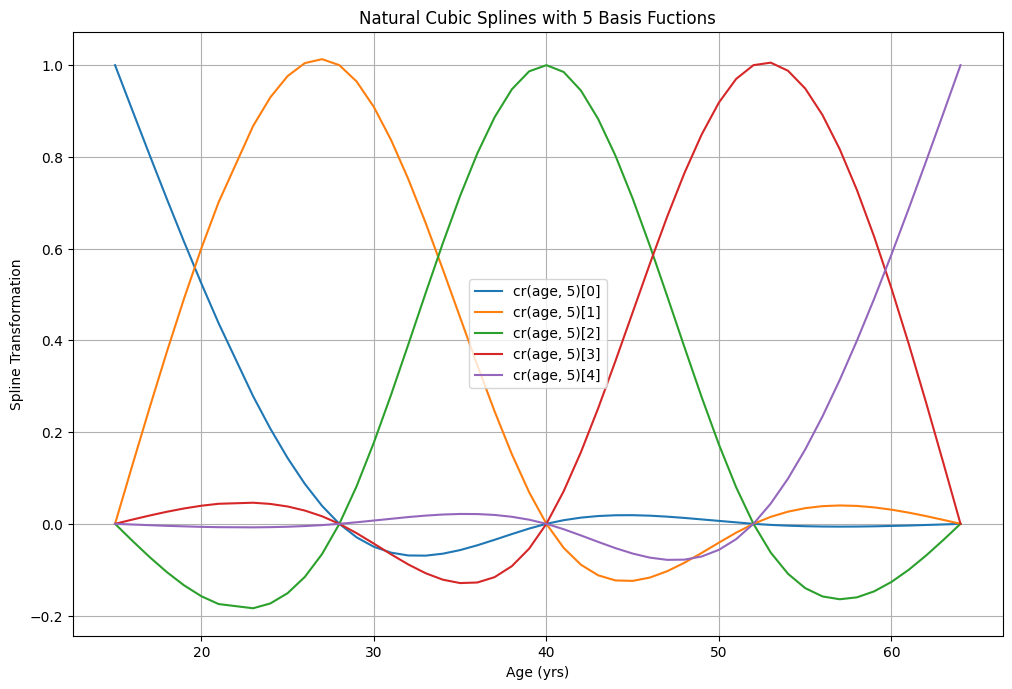

In [15]:
age = dat['age'].sort_values()
x_dmat = dmatrix("cr(age, 5)-1",
                 {"age": age}, return_type='dataframe')
plt.grid(True)
for basis in x_dmat.columns:
    plt.plot(age, x_dmat[basis], label=basis)
plt.xlabel("Age (yrs)")
plt.ylabel("Spline Transformation")
plt.legend()
plt.title("Natural Cubic Splines with 5 Basis Fuctions");

- The image below shows how a different number of knots/degrees of freedom affect the shape of the curve


- Notice that the curve for 3 knots fits better than the linear model using AIC as the fit metric

Linear Model AIC: 529.56


/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


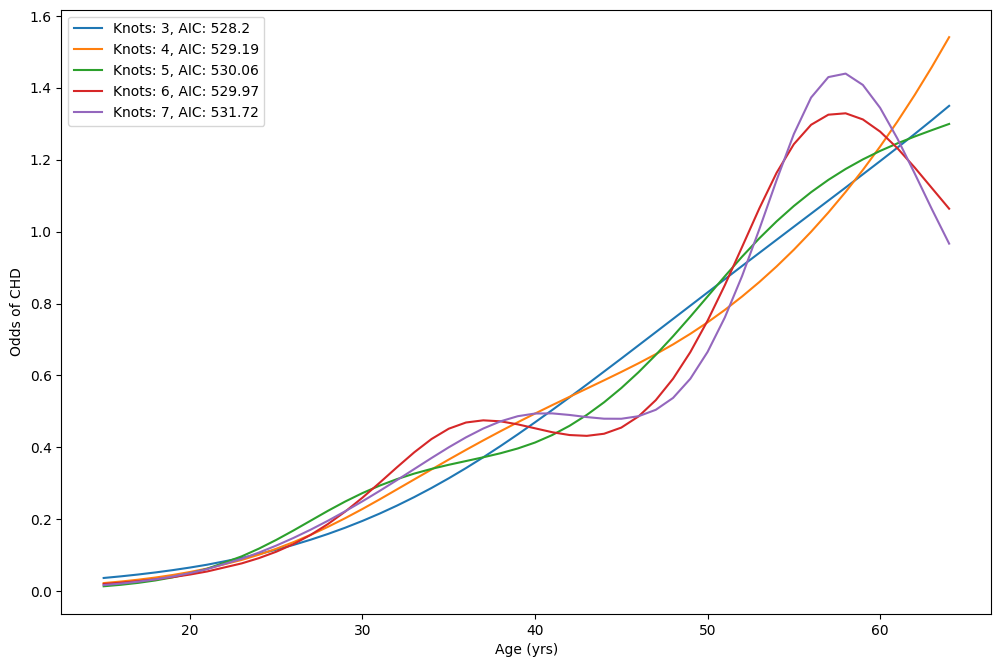

In [16]:
age_dat = sm.add_constant(dat['age'])
results = sm.Logit(dat.chd, age_dat).fit(disp=0)
print(f'Linear Model AIC: {np.round(results.aic, 2)}')

for num_knots in range(3,8):
    fmla = f"cr(age, {num_knots})"
    x_dmat = dmatrix(fmla, {"age": dat['age']})
    results = sm.Logit(dat.chd, x_dmat).fit(disp=0)
    y = np.exp(np.dot(x_dmat, results.params))
    x,y = zip(*sorted(zip(dat['age'].tolist(), y)))
    lab = f"Knots: {num_knots}, AIC: {np.round(results.aic, 2)}"
    plt.plot(x, y, label=lab);

plt.xlabel('Age (yrs)')
plt.ylabel('Odds of CHD')
plt.legend();

- I'm showing the model output below 
- In general, the `coef` values are must less useful than the associated graphic shown below the regression results

In [17]:
x_dmat = dmatrix("cr(age, 3)", {"age": dat['age']})
results = sm.Logit(dat.chd, x_dmat).fit(disp=0)
results.summary()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      459
Method:                           MLE   Df Model:                            2
Date:                Tue, 08 Mar 2022   Pseudo R-squ.:                  0.1240
Time:                        10:49:55   Log-Likelihood:                -261.10
converged:                      False   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 8.955e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9389        nan        nan        nan         nan         nan
x1            -2.3607        nan        nan        nan         nan         nan
x2             0.1833        nan        nan        nan         nan         nan
x3             1.2386        nan        nan        nan         nan         nan
==============================================================================
"""

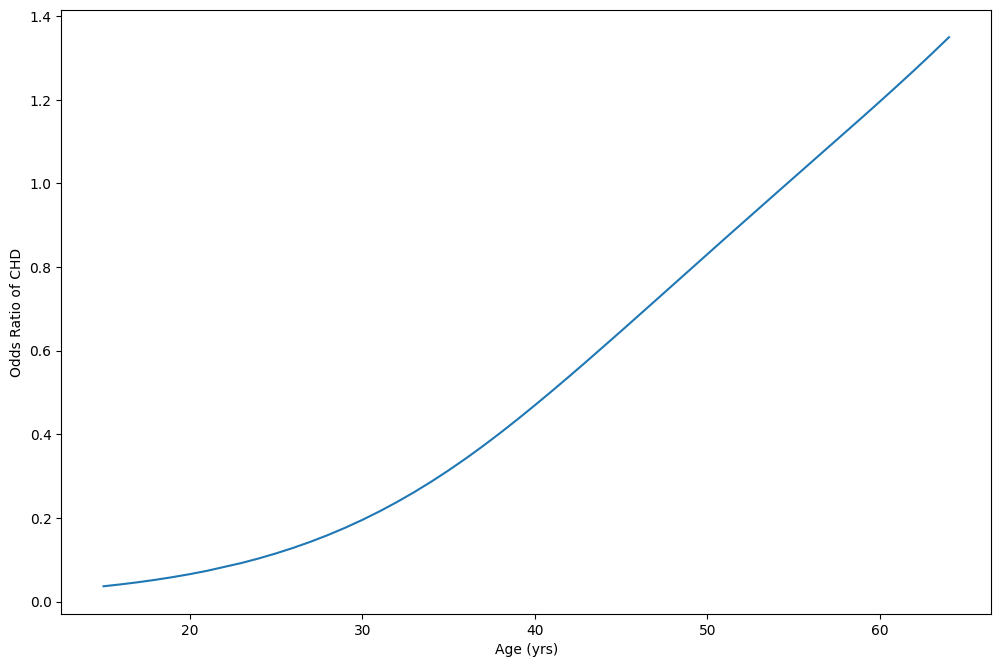

In [18]:
y = np.exp(np.dot(x_dmat, results.params))
x,y = zip(*sorted(zip(dat['age'].tolist(), y)))
plt.plot(x, y);
plt.xlabel('Age (yrs)')
plt.ylabel('Odds Ratio of CHD');

### B-Splines

- B-splines are a little more mathematically complex but computationally very fast because they are generated recursively


- Assume you choose $K$ knots within the domain of $x$: $\xi_1, \dots, \xi_K$ and you choose to use an order $M$ spline


- Let $\xi_0$ and $\xi_{K+1}$ be the boundary knots that to be the scalar domain for the spline function


- Let $\tau_1\leq\tau_2\leq \dots\leq\tau_M\leq\xi_0$


- Let $\tau_{j+M}=\xi_j, j=1,\dots,K$


- Let $\xi_{K+1}\leq \tau_{K+M+1}\leq\tau_{K+M+2}\leq \dots\leq\tau_{K+2M}$


- Denote $B_{i,m}(x)$ to be the $i$th B-spline basis function of order $m$ for the knot sequence $\tau, m\leq M$
$$
B_{i,1}(x) = \begin{cases}
1 \qquad \text{if } \tau_i\leq x<\tau_{i+1} \\
0 \qquad \text{otherwise}
\end{cases}
$$
for $i=1,\dots, K+2M-1$ and 
$$
B_{i,m} = \frac{x-\tau_i}{\tau_{i+m-1}-\tau_i}B_{i,m-1}(x)+\frac{\tau_{i+m}-x}{\tau_{i+m}-\tau_{i+1}}B_{i+1,m-1}(x)
$$
for $i=1,\dots, K+2M-m$

![](./bsplineESL.png)

Image from Elements of Statistical Learning

**B-splines in `statsmodels`**

- very easy to implement B-splines in `statsmodels`


- need to specify `df`, degrees of freedom/number of basis functions


- knots placed at quantiles by default but can also be specified


- 3rd order B-splines are most commonly used
    - seems unlikely to ever need higher than 3rd order
    
    
- There are multiple ways to run B-splines in `statsmodels`


- Below uses `R`-style formulas

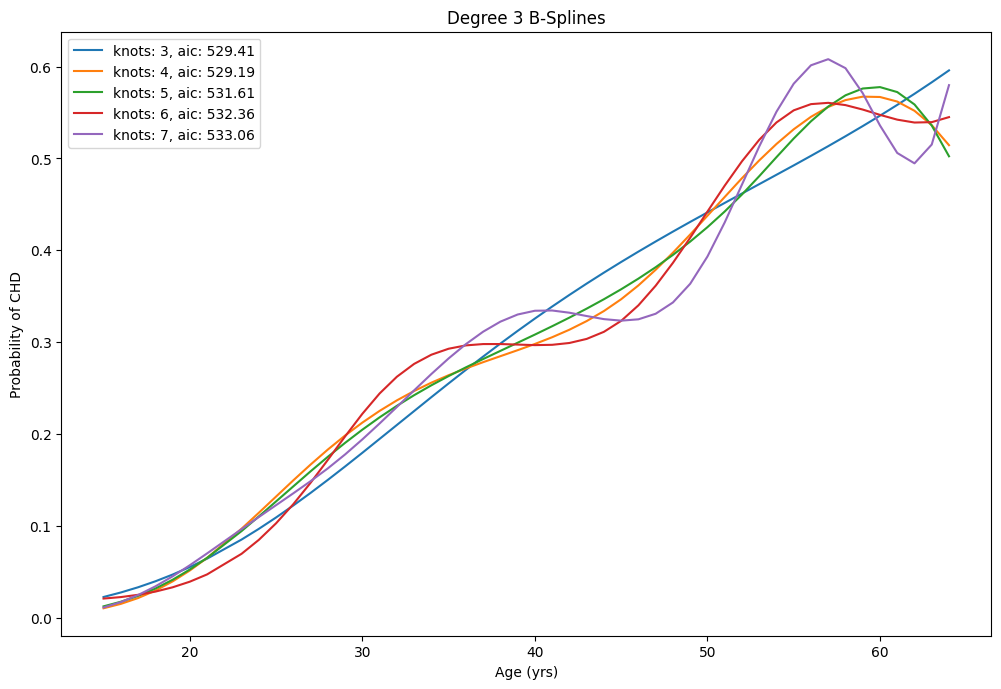

In [19]:
for knots in range(3,8):
    fmla = f"chd ~ bs(age, {knots})"
    modelBS = sm.GLM.from_formula(fmla, data=dat,
                                  family=sm.families.Binomial())
    results = modelBS.fit()
    x,y = zip(*sorted(zip(dat['age'].tolist(), results.predict())))
    lab = f"knots: {knots}, aic: {np.round(results.aic, 2)}"
    plt.plot(x, y, label=lab);

plt.xlabel('Age (yrs)')
plt.ylabel('Probability of CHD');
plt.title('Degree 3 B-Splines')
plt.legend();

### Generalized Additive Model Selection 


- Splines with multiple variables are called generalized additive models (GAMs)


- Model structure:
$$
g(E[Y]) = \beta_0 + \beta_1 h_1(x_1) + \cdots + \beta_p h_p(x_p)
$$
    - where $h_j(x_j)$ is a vector valued function (each entry is the output of a basis function) 
    - with $\beta_j$ the corresponding parameter estimates

$$\\[0.5in]$$

- Question: Which are reasonable ways to fit a GAM? (select all that apply)
    - A. Forward step-wise selection using AIC
    - B. Backward step-wise selection using Deviance
    - C. Using an $L_1$ (lasso) penalty and cross validation
    - D. Choosing variables and degrees of freedom based on visual inspection
    - E. Choosing variables and degrees of freedom based on expert opinion

$$\\[0.5in]$$

- There are many different schools of thought and opinions on model fitting:

    - Common: Simpler is better

    - Less common: Data are never linear, if there is enough data, more complex models can capture non-linearity

    - When choosing a spline model fitting strategy consider the analysis goals compared to what the strategy will provide


- Rule: after selecting between many different models using a single dataset, the inference is no longer valid on the training data


- In *theory*, AIC (BIC) removes selection bias
    - Sometimes statisticians will use this justify inference on models after AIC model selection


- In practice, AIC does not remove all selection bias



- In general, GAM model selection is an area of active research


#### Forward Step-Wise Model Selection


- Here, we take a simple, forward-stepwise approach using AIC: at each step, we will include the variable and spline model that best improves fit


- Challenge is that we must decide on smoothing level/degrees of freedom for each variable


- When prediction is a model goal, including all variables will add random noise to the model


- To avoid this, we perform variable selection


![Foward stepwise selection](forward-stepwise-algorithm.png)
Image from Quantifying Health


- Idea: Add one variable at a time to the model based on a fit metric (AIC, deviance, BIC, etc)



- Algorithm:
    - Start with the intercept model
    - At each step, loop through remaining variables, including one variable to the model
    - Compute fit metric for each new model
    - Chose model with best fit
    - Continue until removing variable no longer improves fit or there are no variables left


- Note: Categorical variables with more that two levels are usually split into multiple dummy variables, usually we will want to include or exclude the entire categorical variable.  Stepwise selection can be tricky in this setting


- Backward stepwise selection is anther, related way to do variable selection

$$\\[0.5in]$$

- Question: Why are we not using cross validation to do variable selection? (select all that apply)
    - A. Because AIC/BIC removes selection bias
    - B. Because we would have to split the data
    - C. Because there are $2^6 = 64$ models to consider without using splines
    - D. Because we are doing prediction

$$\\[0.5in]$$

- Coding note: remember DRY (don't repeat your self)


- Because we will be doing this multiple times, write a function


**Coding with GAMs**

- Note on `statsmodels`: The `gam` method that works fine for fitting the model, but prediction was an issue me


- The [documentation](https://www.statsmodels.org/stable/gam.html#examples) shows a prediction method but I was not able to get it to work


- Prediction for these models is super important because that is primarily what you use to how the relationship between the variables and outcome using plots


- Recommendation: use `sm.glm.from_formula` or `sm.ols.from_formula` with the `bs` operator to indicate that you want to use a spline


- Example `'chd ~ bs(sbp, 3)'` uses 3 knots (and an intercept), the default is to use degree=3


- `sm.gam.BSplines(sbp, df=4, degree=3)` gives the same spline model as above, `df=4` means 3 knots

In [20]:
from statsmodels.gam.api import GLMGam

def fstep_aic(dat, outcome, fixed):
    '''
    Forward stepwise spline fitting with AIC
    input:
        dat = pandas data frame
        outcome = dependent variable name
        fixed = list of tuples to keep fixed with (var_name, df)
    output: list of models with AIC
    '''
    model_data = []
    fmla = f'{outcome}~'
    vrbls = dat.columns.to_list()
    vrbls.remove(outcome)
    fixed_var = []
    fixed_df = []
    for var in fixed:
        if var[0] in vrbls: 
            vrbls.remove(var[0])
            fmla = fmla + f'{var[0]}+'
        if var[1]>1:
            fixed_var.append(var[0])
            fixed_df.append(var[1])
    for var in vrbls:
        c_fmla = fmla + var
        if np.issubdtype(dat.dtypes[var], np.number):
            deg_free = [1,4,5,6,7]
        else:
            deg_free = [1]
        for free in deg_free:
            if any([x>1 for x in [free]+fixed_df]):
                if free>1:
                    c_vars = [var]+fixed_var
                    dfs = [free]+fixed_df
                else:
                    c_vars = fixed_var
                    dfs = fixed_df
                smoothing = sm.gam.BSplines(
                    dat[c_vars], df=dfs, 
                    degree=(len(dfs))*[3])
                model = GLMGam.from_formula(
                    c_fmla, data=dat, smoother=smoothing,
                    family=sm.families.Binomial())
            else:
                model = sm.GLM.from_formula(
                    c_fmla, data=dat,
                    family=sm.families.Binomial())
            results = model.fit()
            c_model = {'Spline': var, 'DF': free,
                       'AIC': round(results.aic, 2)}
            model_data.append(c_model)
        model_aic = pd.DataFrame.from_records(model_data)
    return(model_aic.sort_values(by='AIC'))

# running splines controlling for linear variables
#fstep_aic(dat, vars, fmla, fixed=[])
fstep_aic(dat, 'chd', fixed=[])

,Spline,DF,AIC
23,age,5,529.19
22,age,4,529.41
21,age,1,529.56
24,age,6,531.61
25,age,7,532.36
7,tobacco,5,550.13
9,tobacco,7,552.42
8,tobacco,6,553.11
6,tobacco,4,555.66
5,tobacco,1,558.65


- Table above give AIC when including each variable/df pair as a the only variables in the model


- Question: Which model should we start with?
    - A. age, df = 5, AIC = 529.19
    - B. age, df = 4, AIC = 529.41
    - C. age, df = 1, AIC = 529.56
    - D. age, df = 6, AIC = 531.61
    - E. Not sure

$$\\[1in]$$

- `df=1` means we're using a linear model


- There are no `df=2` nor `df=3` models because cubic spline with 1 knots has at least 4 parameters

In [21]:
fstep_aic(dat, 'chd', fixed=[('age',5)])

,Spline,DF,AIC
15,famhist,1,513.13
10,ldl,1,519.50
5,tobacco,1,521.49
11,ldl,4,522.80
7,tobacco,5,523.37
12,ldl,5,523.98
6,tobacco,4,524.41
13,ldl,6,524.52
8,tobacco,6,525.72
14,ldl,7,526.17


In [22]:
fstep_aic(dat, 'chd', fixed=[('age', 5), ('famhist', 1)])

,Spline,DF,AIC
5,tobacco,1,504.18
7,tobacco,5,505.41
10,ldl,1,505.56
6,tobacco,4,507.40
8,tobacco,6,507.94
9,tobacco,7,508.69
11,ldl,4,509.32
13,ldl,6,509.98
12,ldl,5,510.40
14,ldl,7,511.89


In [23]:
fstep_aic(dat, 'chd', fixed=[('age', 5), ('famhist', 1), 
                             ('tobacco', 1)])

,Spline,DF,AIC
5,ldl,1,496.93
6,ldl,4,500.62
8,ldl,6,501.41
7,ldl,5,501.83
9,ldl,7,503.37
2,sbp,5,504.87
0,sbp,1,504.88
1,sbp,4,505.68
10,obesity,1,505.99
11,obesity,4,506.01


In [24]:
fstep_aic(dat, 'chd', fixed=[('age', 5), ('famhist', 1), 
                             ('tobacco', 1), ('ldl', 1)])

,Spline,DF,AIC
6,obesity,4,495.43
2,sbp,5,496.72
7,obesity,5,496.93
5,obesity,1,497.26
0,sbp,1,498.03
3,sbp,6,498.15
1,sbp,4,498.62
8,obesity,6,498.68
4,sbp,7,499.54
9,obesity,7,500.59


In [25]:
fstep_aic(dat, 'chd', fixed=[('age', 5), ('famhist', 1), 
                             ('tobacco', 1), ('ldl', 1), 
                             ('obesity', 4)])

,Spline,DF,AIC
2,sbp,5,494.80
0,sbp,1,495.95
3,sbp,6,496.43
1,sbp,4,496.53
4,sbp,7,497.54


- We can stop here because there are no variables left


- We should compare the best spline model above with the intercept only model just to be sure and take a look at the linear glm with all variables

In [26]:
incpt_model = sm.GLM.from_formula('chd ~ 1', data=dat, 
    family=sm.families.Binomial()).fit()
print(f"Intercept Model, AIC: {np.round(incpt_model.aic,2)}")

Intercept Model, AIC: 598.11


In [27]:
fmla = 'chd ~ sbp + tobacco + ldl + famhist + obesity + age'
glm_model = sm.GLM.from_formula(
    fmla, data=dat, family=sm.families.Binomial()).fit()
print(f"GLM Linear Model, AIC: {np.round(glm_model.aic,2)}")

GLM Linear Model, AIC: 497.19


- So, the spline model has a better fit here than either the (linear) GLM and the intercept model

$$\\[0.5in]$$

- Question: How should we present the forward selection GAM model? (select all that apply)
    - A. Table with parameters
    - B. AIC is sufficient
    - C. Spline curve plots
    - D. Table with variables and predictions
    - E. Table with AIC for each step

$$\\[0.5in]$$


- Creating best forward-selection, AIC model using `bs` function


- Again, `df` in `BSplines` is one more than the `knots` parameter in the `bs` function


- Reminder: always take a look at the documentation


- Below: plotting splines as probabilities


- Each plot holds all other variable median values constant while varying one variable

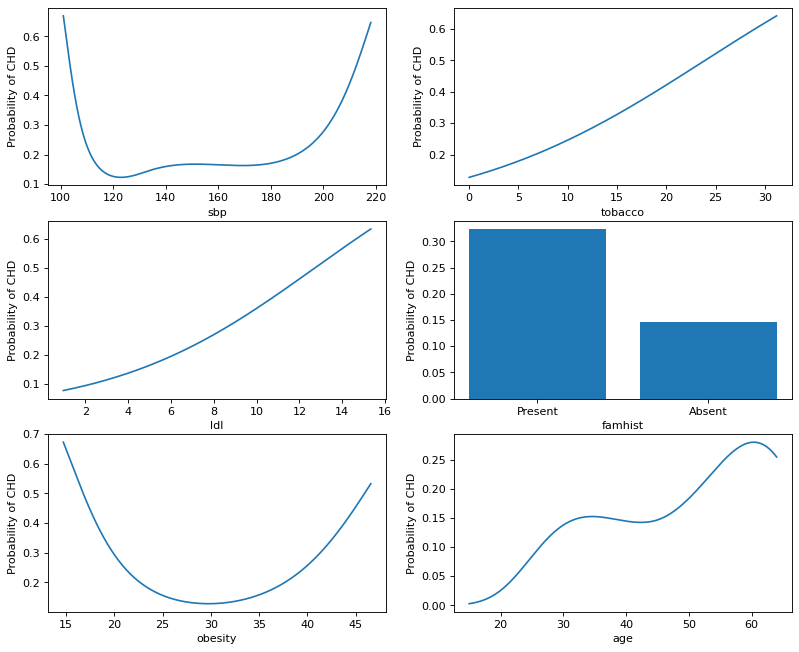

In [28]:
fmla = 'chd~bs(age,4)+famhist+tobacco+ldl+bs(obesity,3)+bs(sbp,4)'

fsw_model = sm.GLM.from_formula(
    fmla, data=dat, family=sm.families.Binomial())
fsw_results = fsw_model.fit()

vrbls = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']

def get_median_mode(vrbls, num):
    d_mat = {}
    for var in vrbls:
        if np.issubdtype(dat[var].dtype, np.number):
            d_mat[var] = dat[var].median()
        else:
            d_mat[var] = dat[var].mode()
    d_mat = pd.DataFrame(d_mat)
    return(sm.add_constant(pd.concat([d_mat]*num)))

def plot_spline(var, plt, fsw_results, dat):
    if np.issubdtype(dat[var].dtype, np.number):
        num = 500
        d_mat = get_median_mode(dat, num)
        d_mat[var] = np.linspace(dat[var].min(), dat[var].max(), num)
        y = fsw_results.predict(exog = d_mat)
        plt.plot(d_mat[var], y)
    else:
        d_mat = get_median_mode(dat, dat[var].nunique())
        d_mat[var] = dat[var].unique()
        y = fsw_results.predict(exog = d_mat)
        plt.bar(d_mat[var], y)
    plt.set(xlabel=var, ylabel='Probability of CHD')

fig=plt.figure(figsize=(12, 10), dpi=80)
#plt.title(f'Probability of CHD by {var} for median observation')
for itr, var in enumerate(vrbls):
        ax=fig.add_subplot(3, 2, itr+1)
        plot_spline(var, ax, fsw_results, dat)

- Question: Are these results counterintuitive to you? (Choose one)
    - A. Yes
    - B. No
    - C. Not sure

$$\\[0.5in]$$

- Question: What should be done to make this publication quality? (Choose all that apply)
    - A. Include title
    - B. Separate individual plots
    - C. Include units for each variable
    - D. Make each spline a different color
    - E. Use odds ratio values for $y$-axis instead of probability of CHD

$$\\[0.5in]$$

- Results explanation example for obesity: 

Figure [number] provides the modeled expected probability of CHD from each risk factor while holding all other variables constant at their median (mode) values.  For example, the obesity spline curve varies obesity (BMI) while fixing median values of age, LDL, and all other variables used in the model.  The U-shape of the curve indicates that those with the least and greatest BMI, at the time the survey was taken, had the greatest risk of CHD while those with a BMI closer to the center tended to have a lower risk of CHD.  This finding is counterintuitive and may be due, in part, to the fact that for this case-control study, BMI was taken at the time of the survey, rather than at the time of CHD.  The lower BMI may actually have been a result of CHD, as CHD patients are encouraged to lower their BMI.  This U-shaped relationship is missed when using a model that assumed linear relationships, see model [model number] in appendix.


- It is not necessary to explain each plot
    - explaining the plots with different shapes is probably sufficient because the reader can infer meaning for similar plots


- Presentation tip: use a grid to present these figures
    - This way the reader can take in more information at once
    - If $x$-axes were on the same scale, I would have plotted them together
    - In general, you want to hit a balance between too much and too little graphical information


- These effects at first may come as a surprise, but an explanation lies in the nature of the retrospective data. These measurements were made sometime after the patients suffered a heart attack, and in many cases they had already benefited from a healthier diet and lifestyle, hence the apparent increase in risk at low values for obesity and sbp. (from ESL)


- This model suffers from collider bias, conditioning on `obesity` and `ldl` which are down-stream effects of `chd`


- Check again to see if it was possible to see the U-shape from the EDA


- This example is from ESL.  Check out how ESL does it in section 5.2.2


- How to make a single prediction below

In [29]:
value =  {'sbp': 134, 'tobacco': 2, 'ldl': 4.34,
     'famhist': 'Absent', 'obesity': 25.805, 'age': 45}
fsw_results.predict(value)

0    0.146415
dtype: float64

- Take a look at the model parameters

In [30]:
fsw_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                            GLM   Df Residuals:                      447
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -232.40
Date:                Tue, 08 Mar 2022   Deviance:                       464.80
Time:                        10:49:56   Pearson chi2:                     475.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2474
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.9651      1.876     -1.048      0.295      -5.641       1.711
famhist[T.Present]     1.0231      0.232      4.409      0.000       0.568       1.478
bs(age, 4)[0]          5.5310      2.160      2.561      0.010       1.298       9.764
bs(age, 4)[1]          2.7024      1.292      2.091      0.037       0.170       5.235
bs(age, 4)[2]          5.2463      1.583      3.314      0.001       2.144       8.349
bs(age, 4)[3]          4.7688      1.387      3.438      0.001       2.050       7.488
tobacco                0.0803      0.027      3.017      0.003       0.028       0.132
ldl                    0.2106      0.059      3.572      0.000       0.095       0.326
bs(obesity, 3)[0]     -4.0650      3.108     -1.308      0.191     -10.156       2.026
bs(obesity, 3)[1]     -2.7604      1.630     -1.693      0.090      -5.956       0.435
bs(obesity, 3)[2]     -0.5900      2.769     -0.213      0.831      -6.016       4.836
bs(sbp, 4)[0]         -3.3098      1.550     -2.136      0.033      -6.347      -0.272
bs(sbp, 4)[1]         -1.1994      1.155     -1.039      0.299      -3.463       1.064
bs(sbp, 4)[2]         -3.4963      2.019     -1.732      0.083      -7.454       0.461
bs(sbp, 4)[3]         -0.1001      1.550     -0.065      0.949      -3.138       2.938
======================================================================================
"""

- showing graphics for these is very important because the parameter numbers or very difficult to interpret compared to the spline function

#### Regression Spline Questions

- Question: It is possible to do inference with regression splines.
    - A. True
    - B. False
    - C. Not sure

$$\\[0.5in]$$

- Question: Regression spline models are linear in their parameters
    - A. True
    - B. False
    - C. Not sure

$$\\[0.5in]$$

- Question: A regression spline with more knots will be
    - A. More wiggly
    - B. Less wiggly
    - C. Not sure

$$\\[0.5in]$$

- Question: Natural cubic splines are typically preferred over cubic splines because
    - A. they use fewer parameters
    - B. they are continuous with continuous first and second derivatives
    - C. they force spline linearity beyond data boundaries
    - D. they are mathematically simpler

$$\\[0.5in]$$

- Question: AIC attempts to balance likelihood (model fit) with parameter count
    - A. True
    - B. False
    - C. Not sure

$$\\[0.5in]$$

- Question: Likelihood will always increase with more parameters
    - A. True
    - B. False
    - C. Not sure

$$\\[0.5in]$$



## Smoothing Splines


- Assume the data, $(x_1, y_1), \dots, (x_n, y_n)$ where $x_i$ and $y_i$ are both scalar values for $i=1, \dots, n$ where both $x$ and $y$ are continous


- Recall: Regression splines typically use a heuristic to choose number of knots and knot placement


- *Smoothing splines* circumvent this by placing knots at **each** input, $x_1, \dots, x_n$ while controlling overfitting by **regularization**
    - **Regularization** adds a penalty, $\lambda$ for model complexity
    - Large values of $\lambda$ add greater penalty for model complexity, resulting in a simpler model


- Recall from linear regression, we want to minimize residual sum of squares (RSS):
$$
\text{RSS}(\beta) = \arg\min_\beta \sum_{i=1}^n \left(y_i-x^T\beta\right)^2
$$
where the regression function is $f(x)=x^T\beta$


- For smoothing splines, we want to minimize over all continuous functions with continuous first and second derivatives, plus a complexity term:
$$
\text{RSS}(f,\lambda) = \arg\min_f \sum_{i=1}^n \left[y_i-f(x_i)\right]^2 + \lambda\int[f''(t)]^2 dt
$$
where $\lambda\in(0,\infty)$ is a fixed smoothing parameter that is chosen beforehand


- $\int[f''(t)]^2 dt$ controls wiggle


- If $\int[f''(t)]^2dt = 0$, then $f$ is linear


- If $\int[f''(t)]^2dt$ is large, then $f$ is very wiggly


- Question: If $\lambda=0$ in the optimization above, then (choose all that apply)
    - A. $f$ will be very wiggly
    - B. $f$ will be linear
    - C. $f$ will try to interpolate all points
    - D. $f$ will have high variance
    - E. $f$ will have high bias


$$\\[0.5in]$$

- Question: If $\lambda=\infty$ in the optimization above, then (choose all that apply)
    - A. $f$ will be very wiggly
    - B. $f$ will be linear
    - C. $f$ will try to interpolate all points
    - D. $f$ will have high variance
    - E. $f$ will have high bias


$$\\[0.5in]$$


- So far, this problem seems very difficult because it is not clear how to estimate $f$


- To make the problem easier, we restrict the space of functions we're considering by controlling how wiggly we will allow functions to be


- We can do this by assuming $f$ to be in a [*Sobolev function space*](https://en.wikipedia.org/wiki/Sobolev_space), with metric
$$\|f\|_{k,p} = \left(\sum_{i=0}^k \int |f^{(i)}(t)|^p dt \right)^\frac{1}{p}$$


- Remarkably, $f$, the solution to RSS$(f,\lambda)$, has a finite-dimensional (tractable) solution:
    - natural cubic spline with knots at each $x_i$:
    $$
    f(x) = \sum_{j=1}^n N_j(x)\beta_j = N(x)\beta = N\beta
    $$
    where $N_j(x)$ is the $j$th natural basis function from above and $N(x)$ is the vector-valued function of all basis functions


- Once the transformation is done, RSS can be re-written:
$$
\text{RSS}(\beta, \lambda) = (y-N\beta)^T(y-N\beta)+\lambda\beta^T\Omega_N\beta
$$
where $\{N\}_{ij} = N_j(x_i)$ is a matrix ($j$th transformation of $i$ observation and $\Omega_N = \int N_j''(t)N_k''(t)dt$


- Solution:
$$
\hat \beta = (N^TN+\lambda\Omega_N)^{-1} N^Ty 
$$


- Question: What other optimization solution is this most simimilar to?
    - A. Lasso
    - B. Ridge
    - C. OLS
    - D. SVM
    - E. Not sure

$$\\[0.5in]$$

- Fitted smoothing spline:
$$
\begin{align*}
\hat f(x) &= \sum_{j=1}^n N_j(x)\hat\beta_j = N\hat\beta\\
    &= N(N^TN+\lambda\Omega_N)^{-1}N^Ty \\
    &= S_\lambda y
\end{align*}
$$


- $S_\lambda$ is called the smoother matrix (similar to the hat matrix for linear regression)


- This shows that a smoothing spline is a linear transformation of $y$


**Choosing $\lambda$**

- Because smoothing splines place a knot at each distinct $x$ value, model degrees of freedom (and overfitting) are controlled by choice of $\lambda$


- Smoothing splines have many parameters (the number of distinct $x$ values but because of the penalty, these values are smaller than they would be without the penalty


- Because of this, we cannot talk about degrees of freedom in the same way as prior models, instead we use *effective degrees of freedom*
$$
\text{df}_\lambda = \text{trace}(S_\lambda)
$$


- Because of this change, it is better to fit the model using a *cross validation method*


- Cross validation shows how well a model fits on data it has never seen/used before


- We measure fit using mean squared error:
$$
E[y_i-\hat f(x_i)]^2
$$


- A good fit means that MSE is small


- Cross validation: use many different values of $\lambda$ and corresponding spline function, $f_\lambda$
$$
\hat f = \arg\min_{f_\lambda} \sum_{i=1}^n \left(y_i-f_\lambda(x_i)\right)^2
$$


- Leave-one-out cross validation (LOOCV):
$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^n \left[y_i-\hat f_\lambda^{(-i)}(x_i)\right]^2
$$
where $f^{(-i)}$ is a model that was estimated without using observation $i$


- $\hat f_\lambda^{(-i)}(x_i)$ is fast to compute
$$
\hat f_\lambda^{(-i)}(x_i) = \frac{\hat f_\lambda(x_i)-s_{\lambda,ii}y_i}{1-s_{\lambda,ii}}
$$
where $s_{\lambda,ii} = (S_\lambda)_{ii}$ is the $ii$ entry in the smoother matrix using all of the observations


- Using all of this, the we want to choose the $\lambda$ with best fit this way:
$$
\lambda^* = \arg\min_\lambda \sum_{i=1}^n \left(y_i-\hat f_\lambda^{(-1)}(x_i)\right)^2
=\arg\min_\lambda \sum_{i=1}^n \left(\frac{y_i-\hat f_\lambda(x_i)}{1-s_{\lambda,ii}}\right)^2
$$


- This is helpful because there is no need to refit the model each time


**Bias-Variance Trade Off**


- Recall that we are assuming that the data are generated with some additive random noise
$$y = \underbrace{f(x)}_{\text{true regression function}}+\underbrace{\epsilon}_{\text{noise}}$$
where $\epsilon \sim N(0,\sigma)$ and the true regression function is unknown


- Let $\hat f_\lambda$ be a smoothing spline with hyperparameter $\lambda$


- We want $\hat f_\lambda$ to be close to $f$


- We measure how close $\hat f_\lambda$ is to $f$ using expected mean squared error:
$$E[(\hat f_\lambda(x) - f(x))^2]$$



- There are two measures that can make this value large


- Recall that the bias of $\hat f_\lambda(x)$ is 
$$\text{Bias}(\hat f_\lambda(x)) = E[\hat f_\lambda(x)] - f(x)$$


- Variance of $\hat f_\lambda(x)$ is
$$\text{Var}(\hat f_\lambda(x)) = E[(\hat f_\lambda(x) -E[\hat f_\lambda(x)])^2]$$


- Using $(a+b)^2 = a^2+b^2+2ab$ and the fact that $E[\hat f_\lambda(x)] - f(x)$ is a fixed quantity (not random), we can show that
$$\begin{align}
&E\left[\left(\hat f_\lambda(x) - f(x)\right)^2\right] \\
&= E\left[\left( \hat f_\lambda(x) -E[\hat f_\lambda(x)] +E[\hat f_\lambda(x)] - f(x)\right)^2 \right] \\
&= E\left[ \left( \hat f_\lambda(x) -E[\hat f_\lambda(x)] \right)^2 \right] + E\left[\left( E[\hat f_\lambda(x)] - f(x)\right)^2 \right] \\
&\quad +2E\left[\left(\hat f_\lambda(x) -E[\hat f_\lambda(x)] \right) \left(E [\hat f_\lambda(x)] - f(x) \right)\right] \\
&= \underbrace{E\left[ \left( \hat f_\lambda(x) -E[\hat f_\lambda(x)] \right)^2 \right]}_{\text{Var}(\hat f_\lambda(x))} + \underbrace{\left( E[\hat f_\lambda(x)] - f(x)\right)^2}_{[\text{Bias}(\hat f_\lambda(x))]^2} \\
\end{align}$$


- When $\lambda$ is small, $\hat f_\lambda$ can be wiggly so variance is high but bias is low


- When $\lambda$ is large, $\hat f_\lambda$ will be close to linear so there will be low variance and higher bias


**GLM smoothing splines**


- We can adapt any GLM model to a smoothing spline model using a pentalized log-likelihood:
$$\ell(f;\lambda) =\sum_{i=1}^n \log p(y_i | f(x_i)) -\frac{\lambda}{2}\int[f''(t)]^2dt $$

- For logistic regression, rather than minimize RSS, we use penalized binomial log-likelihood:
$$
\begin{align*}
\ell(f;\lambda) &=\sum_{i=1}^n \left[y_i\log p(x_i)+(1-y_i)\log(1-p(x_i))\right]-\frac{\lambda}{2}\int[f''(t)]^2dt \\
    &= \sum_{i=1}^n \left[y_if(x_i)+\log(1+\exp(f(x_i))\right]-\frac{\lambda}{2}\int[f''(t)]^2dt
\end{align*}
$$


- This model can be optimized using gradient descent (can be tricker to fit in python)

**Smoothing Splines in Python and R**

- There is no clear smoothing spline function for logistic regression within a standard data science python module
    - `statsmodels` does not (as of now) have an explicit smoothing spline method
    - But, the `alpha` parameter in `statsmodels.gam` is list of penalization weights for each variable according to documentation
    - Might be possible to implement smoothing spline using this
    - `scipy.interpolate.UnivariateSpline` [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) indicate that it is a 1-D smoothing spline function for a continuous outcome; however, the `s`, smoothing factor parameter is used to chooses number of knots
    - It seems unclear how the spline is calculated without looking into the code
    - No clear way to extract smoother matrix to run LOOCV for `UniveriateSpline`
    - `CSAPS` may be a better alternative in python


- In R, `smooth.spline` is very close to the method described above, [documentation](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/smooth.spline)
    - `smooth.spline` makes it very easy to run cross validation
    - Does not implement logistic regression as shown above
    - Other R packages: `gam`, `mgcv`

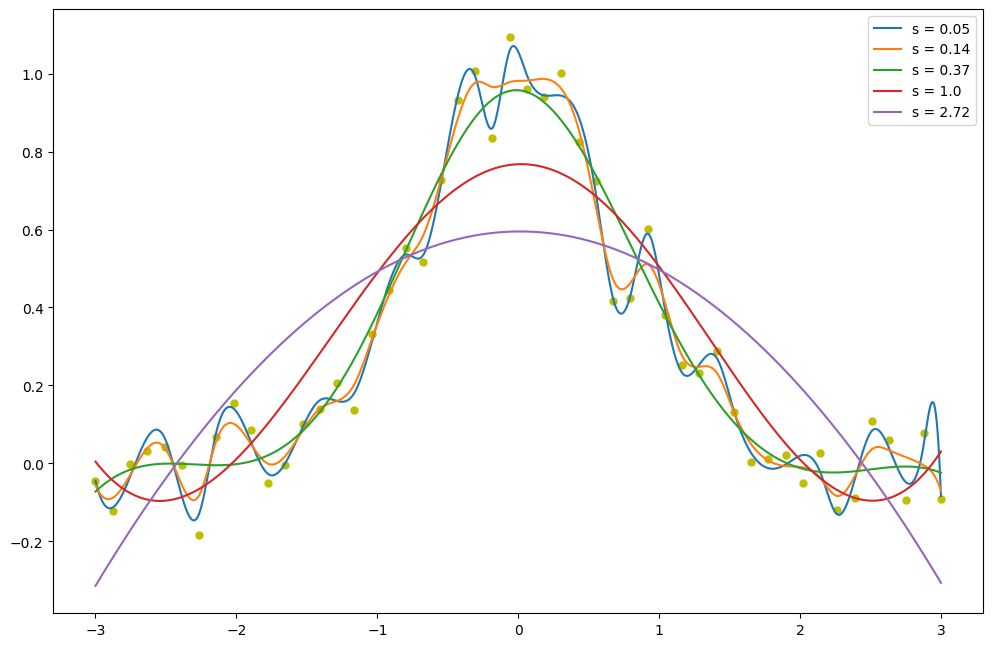

In [31]:
from scipy.interpolate import UnivariateSpline
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
plt.plot(x, y, 'yo', ms=5)

spl = UnivariateSpline(x, y)
xs = np.linspace(-3, 3, 1000)

for itr in range(5):
    sm_fact = np.exp(itr-3)
    spl.set_smoothing_factor(sm_fact)
    plt.plot(xs, spl(xs), label=f"s = {np.round(sm_fact, 2)}")
    plt.legend()


- The code below is an attempt to get `statsmodels` to run a smoothing spline


- Again, cross validation should be used when choosing $\lambda$ (alpha in the model)


- The `loocv` method below needs to be validated before professional use


- I would not recommend using this strategy in python until better smoothing spline methods arise


- Smoothing splines are very developed in R

Unique Ages: 49


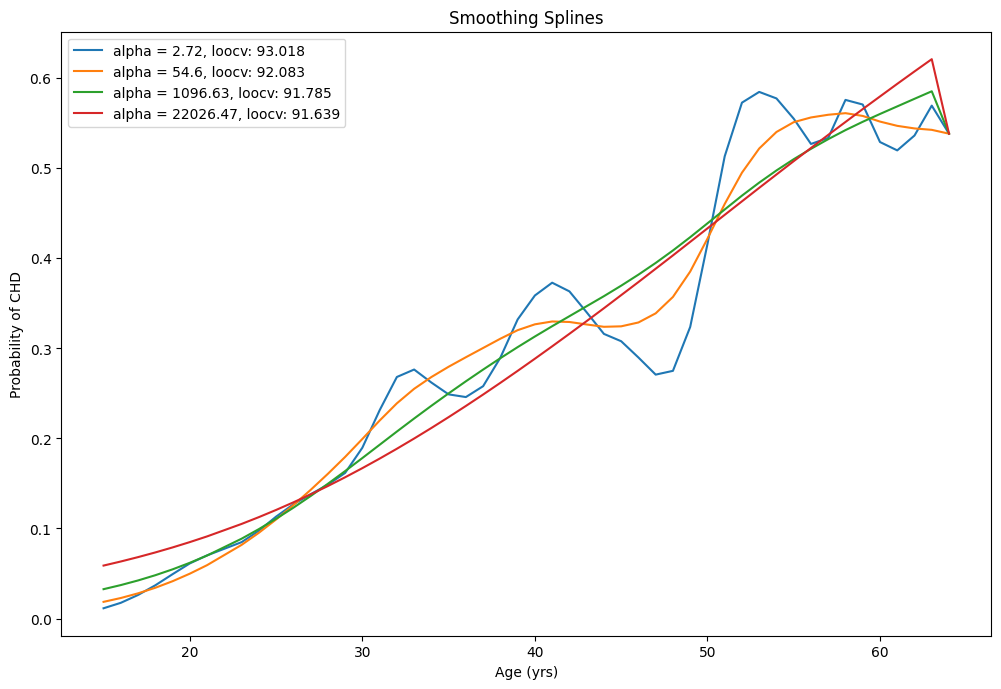

In [32]:
from statsmodels.gam.api import GLMGam

unique_ages = dat.age.nunique()
print(f"Unique Ages: {unique_ages}")

def loocv(results):
    resid = results.resid_response
    #resid = results.resid_deviance
    sii = results.hat_matrix_diag
    return(np.sum(np.square(np.divide(resid, 1-sii))))

for itr in range(4):
    sm_fact = np.exp(3*itr+1)
    fmla = f"chd ~ age"
    smoothing = sm.gam.BSplines(dat['age'], df = unique_ages, degree=3)
    model_smoothing = GLMGam.from_formula(
        fmla, data=dat, alpha = sm_fact, smoother=smoothing,
        family=sm.families.Binomial())
    results = model_smoothing.fit()
    
    x,y = zip(*sorted(zip(dat['age'].tolist(), results.predict())))
    lab = f"alpha = {np.round(sm_fact, 2)}, \
loocv: {np.round(loocv(results), 3)}"
    plt.plot(x, y, label=lab);

plt.xlabel('Age (yrs)')
plt.ylabel('Probability of CHD');
plt.title('Smoothing Splines')
plt.legend();

**Smoothing Spline GAMs**

- This is an easier approach to generalized additive model selection because a machine can quickly evaluate many penalty hyper-parameters then choose the best model based on some fit criteria such as LOOCV, CV, or other criteria like [restricted maximum likelihood](https://en.wikipedia.org/wiki/Restricted_maximum_likelihood) (REML)


- Again, for GAMs,
$$g(E[Y|X=x]) = \sum_{j=1}^p f_j(x_j)$$


- Smoothing splines optimize each $f_j$ with a penalty
$$\hat f_1, \dots, \hat f_p = \arg\min_{f_1,\dots, f_p} \ell(y; f_1,\dots, f_p)+\sum_{j=1}^p \lambda_j\int [f_j''(t)]^2dt$$ where $\ell$ is log-likelihood


- In this optimization, the strongest penalty ($\lambda_j=\infty$) results with $f_j$ being a linear function


- The penalty can be modified to determine remove a variable entirely for the model if it does not contribute to better model fit, [paper](https://web.stanford.edu/~hastie/Papers/gamsel.pdf)


- `pygam` is a smoothing spline approach (uses regularization)


- Below is my attempt to use smoothing spline in python with [pygam](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints), unfortunately, I didn't get it working


- For now, I would recommend using R for smoothing spline GAM selection


- More generally, it is much faster (automatic) to fit GAMs with smoothing splines rather than the stepwise approach with regression splines


- This [article](https://multithreaded.stitchfix.com/blog/2015/07/30/gam/) describes GAMs at a high level and shows how to implement in R with [mgcv](https://cran.r-project.org/web/packages/mgcv/index.html)

In [33]:
from pygam import LogisticGAM, s, te, f

X = dat[['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']].copy()
X['famhist'] = dat['famhist'].apply(lambda x: (x == 'Present')*1)

gam = LogisticGAM(s(0)+s(1)+s(2)+f(3)+s(4)+s(5)).fit(X, dat['chd'])
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     37.4844
Link Function:                        LogitLink Log Likelihood:                                  -219.9498
Number of Samples:                          462 AIC:                                              514.8684
                                                AICc:                                             522.0612
                                                UBRE:                                               3.1793
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.262
Feature Function                  Lam

/var/folders/ky/964c5g8d16v1wyn6pvgg_txh0000gs/T/ipykernel_45657/1646204678.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


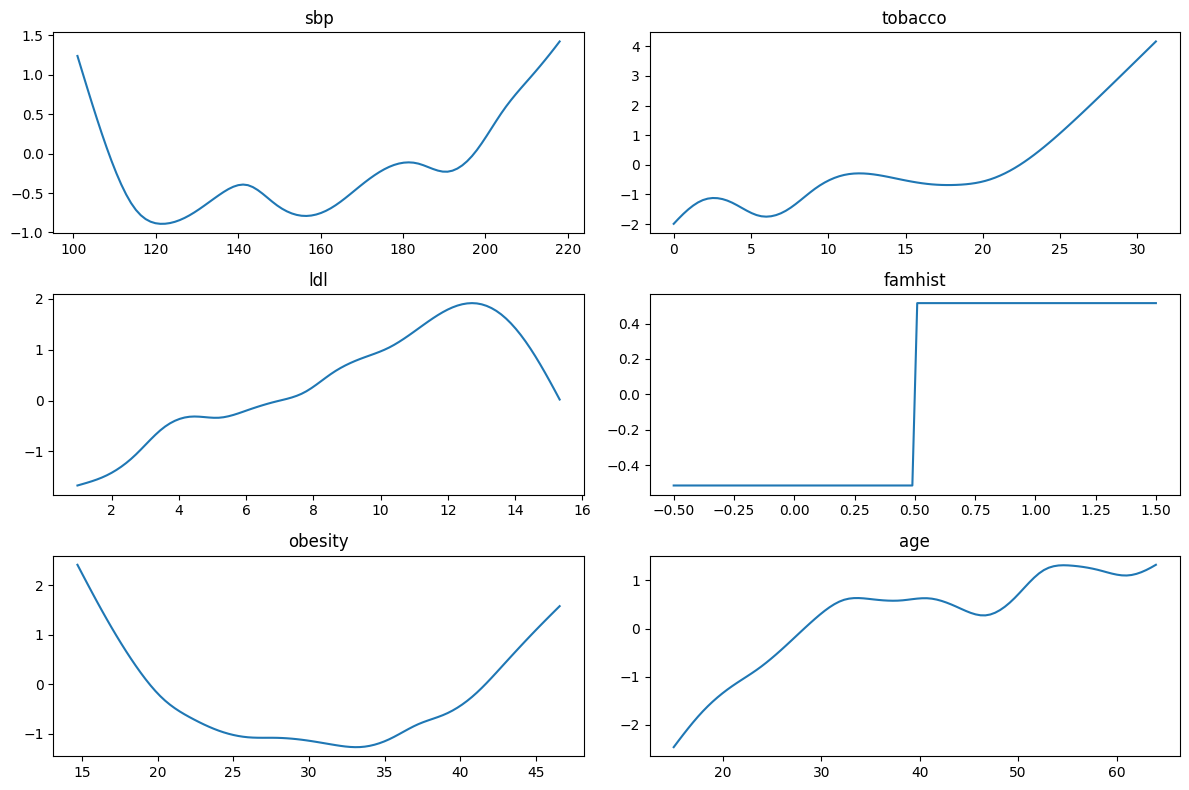

In [34]:
fig = plt.figure();

n_rows = 3
n_cols = 2

titles = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']
for i, ax in enumerate(titles):
    XX = gam.generate_X_grid(term=i)
    ax = fig.add_subplot(n_rows,n_cols,i+1)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.set_title(titles[i]);
fig.tight_layout()

- Question: Does this look more or less complex than the FSW selection?
    - A. More complex
    - B. Less complex

$$\\[0.5in]$$

- The documentation is not clear on how the `fit` function is working


- I suspect that `fit` uses the same $\lambda$ penalty for each spline


- `gridsearch` probably should be used here rather than `fit` but gives an error when run on this data


- This may be because the `famhist` variable has no spline


- It's a good idea to see how other packages do when you're working with less established software


#### Using  R for smoothing spines


- Below using the `gmcv` package from R

In [35]:
%load_ext rpy2.ipython

In [36]:
%%R -i dat

#install.packages('gmcv')
library(mgcv)

gam_fit <- gam(chd~s(sbp)+s(tobacco)+s(ldl)+famhist+s(obesity)+s(age),
              data=dat, family='binomial')
summary(gam_fit)

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.




Family: binomial 
Link function: logit 

Formula:
chd ~ s(sbp) + s(tobacco) + s(ldl) + famhist + s(obesity) + s(age)

Parametric coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -1.3004     0.1744  -7.456 8.89e-14 ***
famhistPresent   0.9387     0.2288   4.103 4.08e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df Chi.sq p-value    
s(sbp)     1.550  1.929  2.868 0.28874    
s(tobacco) 5.646  6.768 16.367 0.01834 *  
s(ldl)     1.000  1.000 11.809 0.00059 ***
s(obesity) 2.057  2.647  4.391 0.18005    
s(age)     3.197  3.991 17.299 0.00173 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.243   Deviance explained = 22.8%
UBRE = 0.063321  Scale est. = 1         n = 462


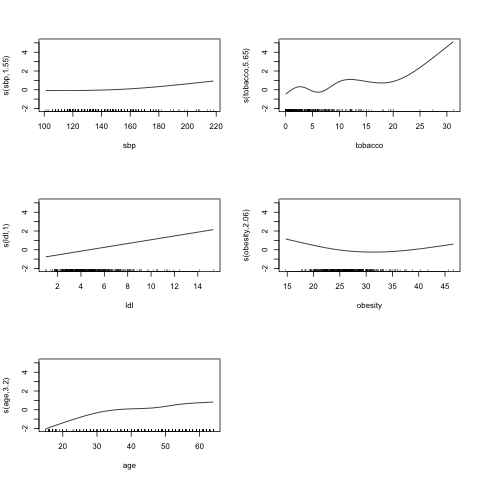

In [37]:
%%R

par(mfrow=c(3,2))
plot(gam_fit, se=FALSE)

### Interactions

- Interactions terms allow the joint values of two or more variables to be estimated separately


- If one variable is discrete, the interaction term allows for separate estimates each each value of the discrete variable


- Interactions can be included for two continuous variables as well
    - to visualize, must choose discrete values of one variable
    
    
- Similar to splines, including interaction terms allow for more model flexibility but uses an additional degree of freedom (parameter to estimate) for each interaction term

![2D interaction Spline Example](https://www.publichealth.columbia.edu/sites/default/files/png/Thin-Plate-Spline.png)

In [38]:
X = dat[['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']].copy()
X['famhist'] = dat['famhist'].apply(lambda x: (x == 'Present')*1)

t_gam = LogisticGAM(te(0,4)+s(1)+s(2)+f(3)+s(5)).fit(X, dat['chd'])
t_gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     30.1366
Link Function:                        LogitLink Log Likelihood:                                  -221.0443
Number of Samples:                          462 AIC:                                              502.3618
                                                AICc:                                             507.0174
                                                UBRE:                                               3.1395
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2584
Feature Function                  Lam

/var/folders/ky/964c5g8d16v1wyn6pvgg_txh0000gs/T/ipykernel_45657/2830460146.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  t_gam.summary()


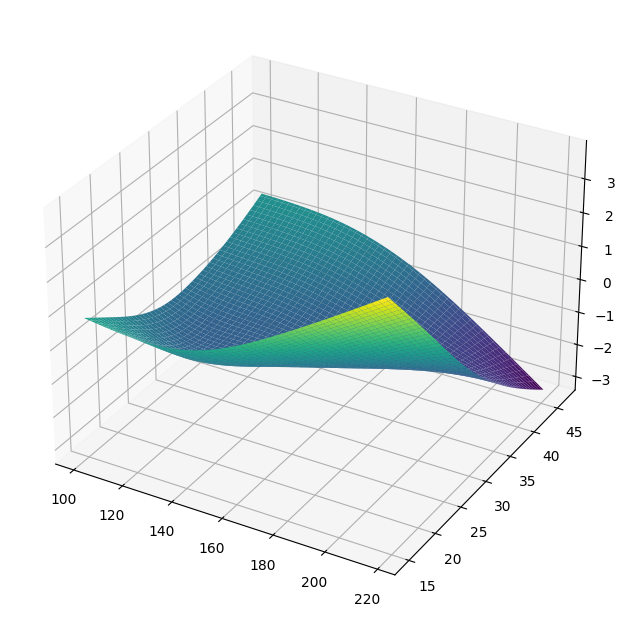

In [39]:
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)

XX = t_gam.generate_X_grid(term=0, meshgrid=True)
Z = t_gam.partial_dependence(term=0, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis');

- Recall the `sbp` and `obesity` were both U-shaped when modeled with separate splines


- Let's look at regression splines and interactions

chd ~ bs(age, 4)*famhist AIC = 517.74
chd ~ age*famhist AIC = 514.07
chd ~ age+famhist AIC = 512.66


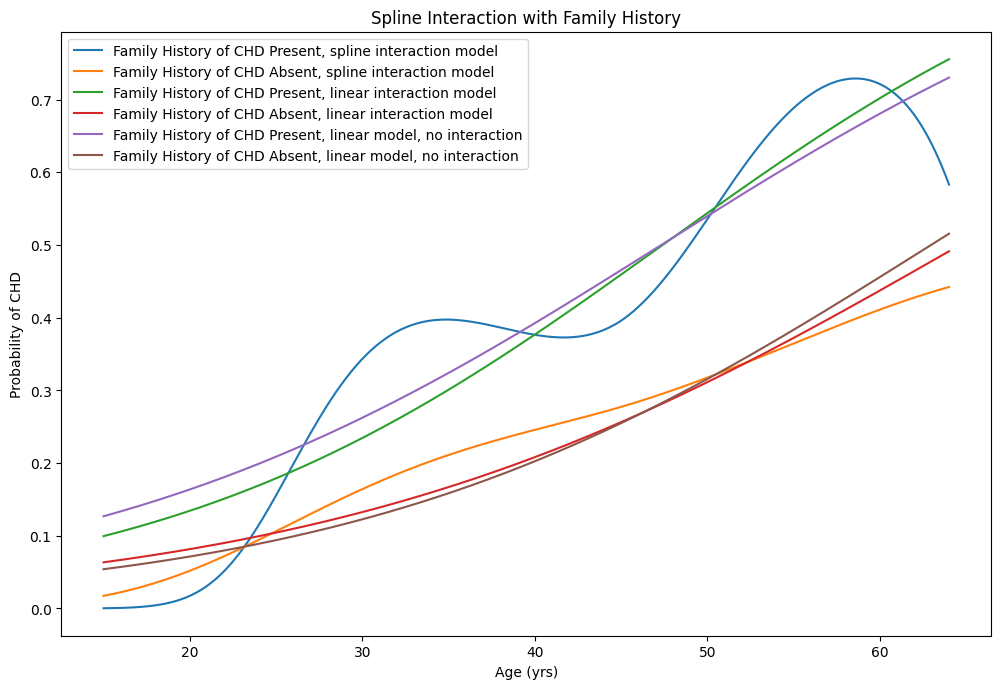

In [40]:
fmla = ("chd ~ bs(age, 4)*famhist", "chd ~ age*famhist",
        "chd ~ age+famhist")
num = 500
age = np.linspace(dat['age'].min(), dat['age'].max(), num)

for mod in range(3):
    modelBS = sm.GLM.from_formula(
        fmla[mod], data=dat, family=sm.families.Binomial())
    results = modelBS.fit()
    print(f"{fmla[mod]} AIC = {np.round(results.aic,2)}")
    for famhist in ('Present', 'Absent'):
        y = results.predict(
            pd.DataFrame({'age': age, 'famhist': famhist}))
        if mod==0:
            lab = f"Family History of CHD {famhist}, \
spline interaction model"
        elif mod==1:
            lab = f"Family History of CHD {famhist}, \
linear interaction model"
        else:
            lab = f"Family History of CHD {famhist}, \
linear model, no interaction"
        plt.plot(age, y, label=lab)
    plt.legend()
    plt.xlabel('Age (yrs)')
    plt.ylabel('Probability of CHD')
    plt.title('Spline Interaction with Family History');

- Looking for interactions
- Below we look for interactions with `famhist`
- You can also look for interactions with spline basis functions as well
- these are sometimes called *tensor products*

In [41]:
fmla_list = [
    'chd~bs(sbp,4)+tobacco+ldl+famhist+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)*famhist+tobacco+ldl+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)+tobacco*famhist+ldl+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)+tobacco+ldl*famhist+bs(obesity,3)+bs(age,4)',
    'chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)*famhist+bs(age,4)',
    'chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)+bs(age,4)*famhist'
]
for fmla in fmla_list:
    fsw_model = sm.GLM.from_formula(
        fmla, data=dat, family=sm.families.Binomial())
    fsw_results = fsw_model.fit()
    print(f"{fmla}, aic: {np.round(fsw_results.aic,2)}")

chd~bs(sbp,4)+tobacco+ldl+famhist+bs(obesity,3)+bs(age,4), aic: 494.8
chd~bs(sbp,4)*famhist+tobacco+ldl+bs(obesity,3)+bs(age,4), aic: 498.99
chd~bs(sbp,4)+tobacco*famhist+ldl+bs(obesity,3)+bs(age,4), aic: 495.68
chd~bs(sbp,4)+tobacco+ldl*famhist+bs(obesity,3)+bs(age,4), aic: 488.05
chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)*famhist+bs(age,4), aic: 500.36
chd~bs(sbp,4)+tobacco+ldl+bs(obesity,3)+bs(age,4)*famhist, aic: 496.0


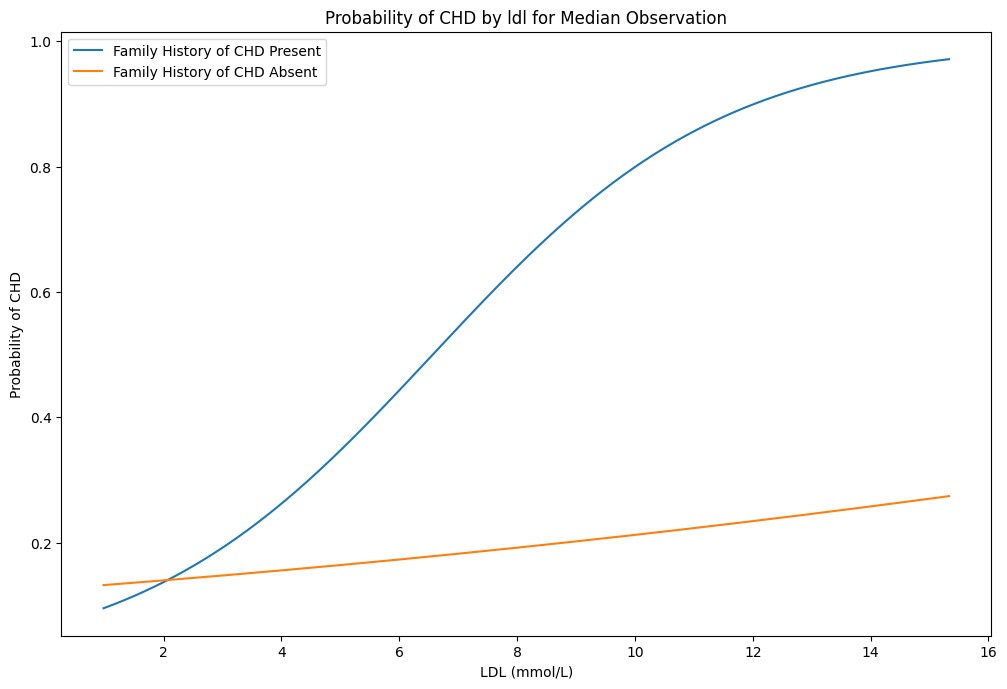

In [42]:
fmla = 'chd~bs(sbp,4)+tobacco+ldl*famhist+bs(obesity,3)+bs(age,4)'
fsw_model = sm.GLM.from_formula(
        fmla, data=dat, family=sm.families.Binomial())
fsw_results = fsw_model.fit()

num = 500
var = 'ldl'
for famhist in ['Present', 'Absent']:
    d_mat = get_median_mode(dat, num)
    d_mat['famhist'] = famhist
    d_mat[var] = np.linspace(dat[var].min(), dat[var].max(), num)
    y = fsw_results.predict(exog = d_mat)
    plt.plot(d_mat[var], y, label = f'Family History of CHD {famhist}')
plt.xlabel('LDL (mmol/L)')
plt.ylabel('Probability of CHD')
plt.title(f'Probability of CHD by {var} for Median Observation')
plt.legend();


### Splines in practice

- Use a model that you understand well enough
    - this is very important when speaking with a client, that you are knowledgeable
- Use a model that easy enough to implement (code)
    - This may change depending on the language you work in
    - for example, I would probably only use a smoothing spline in R
- Overfitting should always be a concern with splines
- Cross validation is the gold standard to avoid over/underfitting but splits data
- AIC is a good runner up in likelihood-based models with easy parameter counts, uses all data
- Splines can be used for interpretation and prediction
    - if accurate prediction is important, cross validation is better than AIC
    - AIC uses the data twice, once to fit and again to evaluate
    - Cross validation avoids this
- Present splines models with graphics
    - Be aware that spline plots choose a fixed value of each model parameter for a spline curve
    - You may want to present more than one value to illustrate how a curve will shift upward or downward depending on the values chosen
    
### Homework Grading Rubric

- Professional
    - language, grammar
    - tables well-formatter, reasonable number
    - helpful, interesting graphics
    - uses headings
    - meets client's needs
    - could use as job interview material
- Intro
    - First sentence is easy to understand and address the subject matter topic
    - Problem and purpose of report is clearly stated
    - Does not use statistical jargon
    - (sometimes) summarize high level findings
- Methods
    - Connects problem, data, and modeling
    - Uses appropriate level of detail for audience
    - Describe statistical model
    - Describe model selection approach
    - shows understanding of possible data nuance (eg including an outcome in a model or repeated information)
- Results
    - Includes a description of the data
    - Describes variables
        - Most of the time, this will require a table
        - For data with a lot of variables, you may need to put table in appendix or skip entirely
    - Variables are explained when initially presented
    - Explains model/parameters in terms of the subject matter
    - Includes a reasonable number of graphics
         - should be well chosen
         - axes must be labels
         - graphic should contain an appropriate amount of information
         - clearly related to topic
         - has a description
    - Modeling
         - presented in a reasonable way given the model (either table or with graphics
         - appropriate for client's needs
         - well explained (eg GLM log parameters exponentiated)
         - Reasonable overall fit with consideration of complexity
- Conclusion
    - Discusses actual and potential limitation
    - Connects results with overall purpose
- Code appendix
    - does not show unhelpful computer output (especially very long output)
    - uses sentences to describe what does is doing and sometimes why
    - Gives granular description of data with tables and plots (these do not need to be perfectly formatted)
    - Looks for issues with data, outliers, influential points etc
    - Includes model diagnostics
    - If you are proving usable code, always include documentation with an example of how to use it
    

Notes based on [Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. The elements of statistical learning. Vol. 1. No. 10. New York: Springer series in statistics, 2001.](http://statweb.stanford.edu/~tibs/book/preface.ps)